# Data Preparation
-------------

The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tools) from the initial raw data. Data preparation tasks are likely to be performed multiple times and not in any prescribed order. Tasks include table, record and attribute selection as well as transformation and cleaning of data for modeling tools.

- Data selection: Decision on the data to be used for analysis. Criteria include relevance to the data mining goals, quality and technical constraints such as limits on data volume or data types.

- Data cleaning: Raise the data quality to the level required by the selected analysis techniques. This may involve selection of clean subsets of the data, the insertion of suitable defaults or more ambitious techniques such as the estimation of missing data by modeling. Transformations of the data for cleaning purposes and the possible impact on the analysis results should be considered.

- Data construction: This task includes constructive data preparation operations such as the production of derived attributes, entire new records or transformed values for existing attributes.

- Data integration: These are methods whereby information is combined from multiple tables or records to create new records or values. Merging tables refers to joining together two or more tables that have different information about the same objects.

- Data formatting: Formatting transformations refer to primarily syntactic modifications made to the data that do not change its meaning, but might be required by the modeling tool.

In [1]:
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

2024-05-20 08:16:44.347007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 08:16:44.347126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 08:16:44.514074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data selection


In [2]:
# load dataset
categories = ["Electronics", "Camera", "Mobile_Electronics", "PC", "Software", "Wireless"]

category_datasets = []
for category in tqdm(categories):
    kaggle_dataset_path = f"/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_{category}_v1_00.tsv"

    category_dataset = pd.read_csv(kaggle_dataset_path, sep='\t', quoting=3)
    category_datasets.append(category_dataset)
    print(f"Loaded dataset for {category}")
    
dataset = pd.concat(category_datasets)
dataset.head()

  0%|          | 0/6 [00:00<?, ?it/s]

Loaded dataset for Electronics
Loaded dataset for Camera
Loaded dataset for Mobile_Electronics
Loaded dataset for PC
Loaded dataset for Software
Loaded dataset for Wireless


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [3]:
# number of columns initially 
dataset.shape[1]

15

In [4]:
# number of records initially 
dataset.shape[0]

21253324

In [5]:
# take only verified purchases from all data purchases
dataset = dataset[dataset.verified_purchase == 'Y']

# take only the reviews which recieved at least 10 votes
dataset = dataset[dataset.total_votes >= 10]

In [6]:
# number of records
dataset.shape[0]

408167

In [7]:
# concatenate review headline and body into one column with name "review"
dataset["review"] = dataset["review_headline"] + "\n" + dataset["review_body"]

In [8]:
dataset = dataset[["review_id", "product_id", "product_category", "helpful_votes", "total_votes", "review"]]

In [9]:
# number of columns after data selection
dataset.shape[1]

6

In [10]:
# number of records after data selection
dataset.shape[0]

408167

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408167 entries, 41 to 9001998
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         408167 non-null  object
 1   product_id        408167 non-null  object
 2   product_category  408167 non-null  object
 3   helpful_votes     408167 non-null  int64 
 4   total_votes       408167 non-null  int64 
 5   review            408050 non-null  object
dtypes: int64(2), object(4)
memory usage: 21.8+ MB


#### Selected data source

| # | Data | Included/excluded | Reasons | Quality | Initial volume | Volume after data selection | Data types |
|:---:|:---|:---|:---|:---|:---| :---| :---|
| 1 | Amazon US Reviews Electronics Dataset + Amazon US Customer Reviews Camera, Mobile Electronics, PC, Software, and Wireless Datasets | Included | The whole dataset provides reliable data and includes all the necessary features for our project objectives (electronics & digital marketplace) | The data is of high quality | (21253324, 15) | (408167, 6) | Integers, objects |

#### Selected attributes & records

We collected only verified purchases from all purchases in the data. Then, we took only the reviews which recieved at least 10 votes. 

The final list of selected features and the corresponding records:

| # | selected attributes | records |
|:---:|:---|:---|
|1	| review_id | all |
|2	| product_id | all |
|3	| product_category | include "Electronics", "Camera", "Mobile_Electronics", "PC", "Software", "Wireless" |
|4	| helpful_votes | all (*further: removed after deriving "usefullness" attribute)|
|5	| total_votes | take review records which recieved at least 10 total votes |
|6	| review (concatenated review_headline and review_body) | all (*further: cleaned from html tags and links, take with length <= 2000 words) |




## Clean data
- Remove missing values
- Clear HTML tags from text
- Fix typos
- Remove links or hyperlinks from reviews
- Remove excessively large reviews 

In [12]:
# clean missing values
dataset = dataset.dropna()

In [13]:
# number of records after data cleaning
dataset.shape[0]

408050

In [14]:
dataset.review_id.nunique(), len(dataset)

(408050, 408050)

In [15]:
def remove_html_tags_and_links(text):
    # remove HTML tags
    cleaned_text = re.sub(r'<[^>]+>', '', text)
    
    # remove hyperlinks
    cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', cleaned_text)
    
    return cleaned_text

In [16]:
# clean reviews
dataset["review"] = dataset["review"].apply(remove_html_tags_and_links)

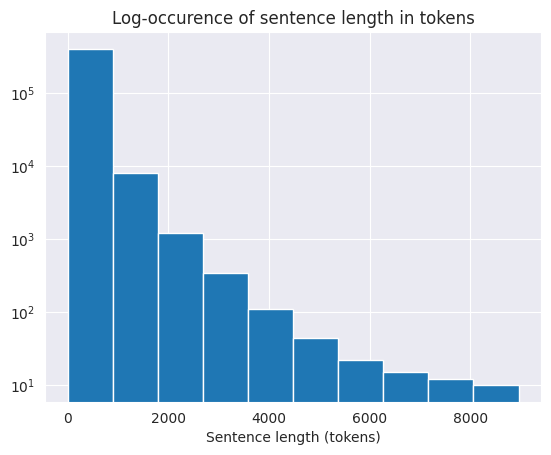

In [17]:
plt.hist(dataset["review"].apply(lambda x: len(x.split())), log=True)
plt.title("Log-occurence of sentence length in tokens")
plt.xlabel("Sentence length (tokens)")
plt.show()

In [18]:
# remove excessively large reviews
dataset = dataset[dataset["review"].apply(lambda x: len(x.split())) <= 2000]

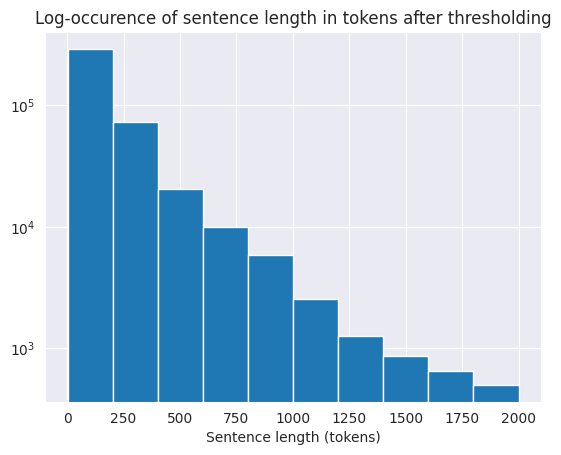

In [19]:
plt.hist(dataset["review"].apply(lambda x: len(x.split())), log=True)
plt.title("Log-occurence of sentence length in tokens after thresholding")
plt.xlabel("Sentence length (tokens)")
plt.show()

## Data construction

- Add derived attributes

In [20]:
# derive attributes
# usefulness -- ratio of helpful_votes and total_votes
dataset["usefulness"] = dataset["helpful_votes"] / dataset["total_votes"]

# remove helpful_votes attributes as it is no more needed
dataset.drop(columns=["helpful_votes"], inplace=True)

In [21]:
dataset.head()

,review_id,product_id,product_category,total_votes,review,usefulness
41,R1FBO737KD9F2N,B00NG57H4S,Electronics,23,Great noise cancelling headphones for the pric...,0.826087
145,R227GSNWI6BSZV,B00ICNXESC,Electronics,20,"Garbage, lasted 8 months... warranty is useles...",1.000000
265,R4PF7S0TOV9S7,B00XR1MW4G,Electronics,17,A long lasting bluetooth sound bazooka!\nThis ...,0.882353
274,R22LKIOKMSOG8A,B00XS3HGEO,Electronics,13,nice!\nThis is a nice little turntable. Don't ...,0.923077
304,R3SJTYZBYBG4EE,B00L108SAW,Electronics,99,Very good charger for the price! But has a dow...,1.000000


## Augment textual data with translation

In [22]:
cycles = [
    [pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru"), pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en")],
    [pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr"), pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")],
]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

In [23]:
def augment_sentence(sent):
    if np.random.random() > 0.001:
        return sent
    cycle = cycles[np.random.randint(len(cycles))]
    try:
        for comp in cycle:
          sent = comp(sent)[0]['translation_text']
        return sent
    except:
        return sent

In [24]:
tqdm.pandas(desc='Augmenting texts')

In [25]:
# dataset["review"] = dataset["review"].progress_apply(augment_sentence)

## Data integration

To enhance the scope of our analysis, we integrated the initial dataset from the [Amazon Reviews US Electronics dataset]((https://www.kaggle.com/datasets/mohitsharma527/amazon-reviews-us-electronics)) with additional datasets from [Amazon US Customer Reviews Datasets](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset) within product categories, including Camera, Mobile Electronics, PC, Software, and Wireless. 

All the data fields were consistent, so we just concatenated all datasets (code provided in the beginning of this notebook: 2 cell).


## Data formatting

The dataset does not require any modifications.

## Save the data

In [26]:
dataset.to_parquet("preprocessed_data.parquet")

In [27]:
!zip data.zip preprocessed_data.parquet

  adding: preprocessed_data.parquet (deflated 13%)


In [28]:
!rm preprocessed_data.parquet

In [29]:
from IPython.display import FileLink
FileLink(r'data.zip')

/kaggle/working/data.zip